In [38]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import os
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from keras import regularizers, applications, callbacks
from keras import optimizers
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.9.2


In [2]:
#use GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from subprocess import getoutput
s = getoutput('nvidia-smi')
if 'K80' in s:
  gpu = 'K80'
elif 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
  display.HTML(f"{gpu}")
print(s)
# or simply
!nvidia-smi -L
     

Tue Jan 17 11:14:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |    312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip "/content/drive/MyDrive/DeepLearn/datasets/vegetables.zip" >/dev/null

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dir = '/content/Vegetable Images/train'
val_dir = '/content/Vegetable Images/validation'
test_dir = '/content/Vegetable Images/test'


train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                            shuffle=True,
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=False,
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


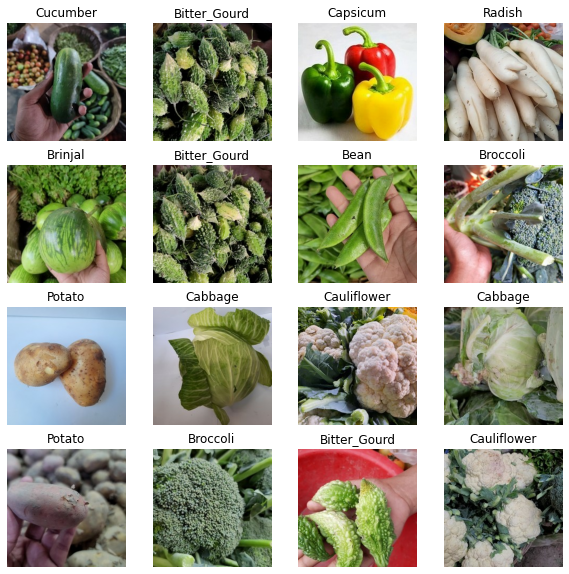

In [6]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)

    plt.imshow(images[i].numpy().astype("uint8"))
    idx = tf.math.argmax(labels[i])
    plt.title(class_names[idx])
    plt.axis("off")

#CNN from scratch

In [26]:
input_shape = IMG_SIZE + (3,)

def conv_block(input, filters, kernel_size, strides, padding):
  X = Conv2D(filters, kernel_size, strides = strides, activation='relu', padding=padding, kernel_initializer = 'glorot_uniform')(input)
  X = BatchNormalization(axis=-1)(X)
  return X

def linear_block(input, filters):
  X = Dense(filters, activation='relu', kernel_initializer = 'glorot_uniform')(input)
  X = Dropout(0.5)(X)
  return X

def CNN(input_shape,classes):

  inputs = Input(shape=input_shape)
  X = tf.keras.layers.Rescaling(scale=1./255)(inputs)
  #similar structure of AlexNet
  X = conv_block(input=X,filters=96, kernel_size=(11,11),strides=(4,4), padding='valid')
  X = MaxPooling2D(pool_size=(2,2), strides=(2))(X)
  X = conv_block(input=X,filters=256, kernel_size=(5,5),strides=(1,1), padding='same')
  X = MaxPooling2D(pool_size=(3,3), strides=(2))(X)
  X = conv_block(input=X,filters=384, kernel_size=(3,3),strides=(1,1), padding='same')
  X = conv_block(input=X,filters=384, kernel_size=(3,3),strides=(1,1), padding='same')
  X = conv_block(input=X,filters=256, kernel_size=(3,3),strides=(1,1), padding='same')
  X = MaxPooling2D(pool_size=(3,3), strides=(2))(X)
  #flatten
  X = Flatten()(X)
  #linear layers
  X = linear_block(X, filters=4096)
  X = linear_block(X, filters=4096)
  outputs = Dense(classes, activation='softmax', kernel_initializer = 'glorot_uniform')(X)

  model = Model(inputs = inputs, outputs = outputs)
  return model

cnn_model = CNN(input_shape=(224, 224, 3), classes=len(class_names))

cnn_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 54, 54, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 27, 27, 256)       6146

In [27]:
lr = 0.001
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

#ResNet#

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(len(class_names), activation='softmax', kernel_initializer = 'glorot_uniform')(x)
pre_model = tf.keras.Model(inputs, outputs)
pre_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                              

In [7]:
lr = 0.001
pre_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

#Training#

In [28]:
epochs = 10

def training(model,epochs, train_dataset, val_dataset):
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3, verbose=1,mode='min')
  history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks = [reduce_lr])
  return history

In [29]:
#training cnn from scratch
history_cnn = training(cnn_model,epochs, train_dataset=train_dataset, val_dataset=val_dataset)

Epoch 1/10
469/469 [==============================] - 45s 66ms/step - loss: 3.8923 - accuracy: 0.4273 - val_loss: 1.6738 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 2/10
469/469 [==============================] - 30s 64ms/step - loss: 1.4434 - accuracy: 0.6195 - val_loss: 1.0702 - val_accuracy: 0.6983 - lr: 0.0010
Epoch 3/10
469/469 [==============================] - 30s 64ms/step - loss: 1.2517 - accuracy: 0.6867 - val_loss: 0.9184 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 4/10
469/469 [==============================] - 30s 64ms/step - loss: 1.0446 - accuracy: 0.7441 - val_loss: 0.6986 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 5/10
469/469 [==============================] - 30s 64ms/step - loss: 0.9572 - accuracy: 0.7783 - val_loss: 2.9781 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 6/10
469/469 [==============================] - 31s 66ms/step - loss: 0.8252 - accuracy: 0.8089 - val_loss: 0.5133 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 7/10
469/469 [==============================] - 30s 

In [9]:
#fine-tune the ResNet50 
history_resnet = training(pre_model,epochs, train_dataset=train_dataset, val_dataset=val_dataset)

Epoch 1/10
469/469 [==============================] - 177s 358ms/step - loss: 2.3938 - accuracy: 0.1959 - val_loss: 1.2987 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 2/10
469/469 [==============================] - 165s 351ms/step - loss: 0.9266 - accuracy: 0.6845 - val_loss: 0.6723 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 3/10
469/469 [==============================] - 164s 350ms/step - loss: 0.5788 - accuracy: 0.8181 - val_loss: 0.3325 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 4/10
469/469 [==============================] - 164s 350ms/step - loss: 0.3221 - accuracy: 0.8965 - val_loss: 0.3437 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 5/10
469/469 [==============================] - 164s 350ms/step - loss: 0.2503 - accuracy: 0.9213 - val_loss: 0.1692 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 6/10
469/469 [==============================] - 164s 350ms/step - loss: 0.2348 - accuracy: 0.9237 - val_loss: 0.1613 - val_accuracy: 0.9483 - lr: 0.0010
Epoch 7/10
469/469 [==========================

#Learning Curves

In [30]:
def learning_curves(history):

  acc = [0.] + history.history['accuracy']
  val_acc = [0.] + history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

---------- CNN LEARNING CURVES ------------




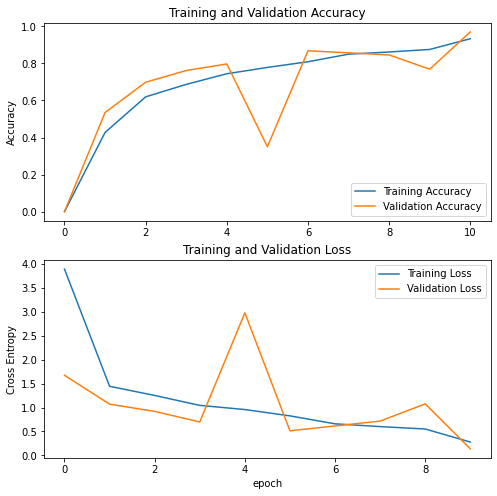

In [31]:
#CNN plots
print('---------- CNN LEARNING CURVES ------------')
print('\n')
learning_curves(history_cnn)

---------- PRE-TRAINED RESNET50 LEARNING CURVES ------------




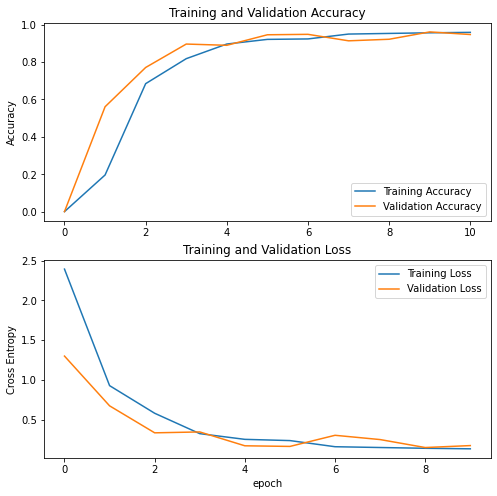

In [12]:
#CNN plots
print('---------- PRE-TRAINED RESNET50 LEARNING CURVES ------------')
print('\n')
learning_curves(history_resnet)

#Performances#

In [32]:
def model_performances(model,test_dataset):
  score = model.evaluate(test_dataset, verbose = 1) 
  print('Test loss:', score[0]) 
  print('Test accuracy:', score[1])

In [33]:
print('-------------- CNN PERFORMANCES ON TEST SET ----------------')
model_performances(cnn_model,test_dataset)

-------------- CNN PERFORMANCES ON TEST SET ----------------
94/94 [==============================] - 3s 33ms/step - loss: 0.1334 - accuracy: 0.9677
Test loss: 0.13340453803539276
Test accuracy: 0.9676666855812073


In [15]:
print('-------------- PRE-TRAINED RESNET50 PERFORMANCES ON TEST SET ----------------')
model_performances(pre_model,test_dataset)

-------------- PRE-TRAINED RESNET50 PERFORMANCES ON TEST SET ----------------
94/94 [==============================] - 10s 101ms/step - loss: 0.2023 - accuracy: 0.9417
Test loss: 0.20225374400615692
Test accuracy: 0.9416666626930237


In [36]:
def PerformancesAndErrors(model, class_names,test_dataset):
  #output model predictions
  preds = model.predict(test_dataset, verbose=1)

  Ypred = np.argmax(preds, axis=1)
  Ytest = np.concatenate([y for x, y in test_dataset], axis=0)  # shuffle=False in test_generator
  Ytest = np.argmax(Ytest, axis=1)

  Ycls_name_pred = []
  Y_test_names = []
  for idx_class,idx_y in zip(Ypred,Ytest):
    Ycls_name_pred.append(class_names[idx_class])
    Y_test_names.append(class_names[idx_y])

  cm = confusion_matrix(Y_test_names, Ycls_name_pred, labels=class_names)
  conf_matrix = pd.DataFrame(cm, index=class_names, columns=class_names)
  print('-----CONFUSION MATRIX--------')
  print(conf_matrix)
  print('\n')
  conf = []  # data structure for confusions: list of (i,j,cm[i][j])
  print('--------ERRORS--------')
  for i in range(0, cm.shape[0]):
    for j in range(0, cm.shape[1]):
      if (i != j and cm[i][j] > 0):
        conf.append([i, j, cm[i][j]])

  col = 2
  conf = np.array(conf)
  conf = conf[np.argsort(-conf[:, col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

  print('%-16s     %-16s  \t%s \t%s ' % ('True', 'Predicted', 'errors', 'err %'))
  print('------------------------------------------------------------------')
  for k in conf:
      print('%-16s ->  %-16s  \t%d \t%.2f %% ' % (
      class_names[k[0]], class_names[k[1]], k[2], k[2] * 100.0 /3000))

In [37]:
#Pre-trained resnet50 performances
print('-------------- CNN CONFUSION MATRIX AND CLASSIFICATION ERRORS ----------------')
print('\n')
PerformancesAndErrors(cnn_model, class_names,test_dataset)

-------------- CNN CONFUSION MATRIX AND CLASSIFICATION ERRORS ----------------


94/94 [==============================] - 4s 39ms/step
-----CONFUSION MATRIX--------
              Bean  Bitter_Gourd  Bottle_Gourd  Brinjal  Broccoli  Cabbage  \
Bean           198             0             0        0         1        0   
Bitter_Gourd     3           190             0        0         0        1   
Bottle_Gourd     0             0           199        0         0        0   
Brinjal          0             0             0      187         1        1   
Broccoli         2             0             0        1       193        1   
Cabbage          0             0             0        0         2      192   
Capsicum         1             0             0        0         0        0   
Carrot           0             0             0        0         0        0   
Cauliflower      1             0             0        0         0        0   
Cucumber         2             0             2        0

In [17]:
#Pre-trained resnet50 performances
print('-------------- PRE-TRAINED RESNET50 CONFUSION MATRIX AND CLASSIFICATION ERRORS ----------------')
print('\n')
PerformancesAndErrors(pre_model, class_names,test_dataset)

-------------- PRE-TRAINED RESNET50 CONFUSION MATRIX AND CLASSIFICATION ERRORS ----------------


94/94 [==============================] - 11s 94ms/step
-----CONFUSION MATRIX--------
              Bean  Bitter_Gourd  Bottle_Gourd  Brinjal  Broccoli  Cabbage  \
Bean           190             3             0        4         0        1   
Bitter_Gourd     0           194             0        0         3        1   
Bottle_Gourd     0             0           189        0         0        0   
Brinjal          1             1             4      182         1        5   
Broccoli         0             1             0        1       192        2   
Cabbage          0             3             0        1         0      196   
Capsicum         3             1             0        0         0        0   
Carrot           0             0             0        0         0        0   
Cauliflower      5             0             1        1         2        9   
Cucumber         0             0     